In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_excel("C:\\Users\\user\\Desktop\\machine\\data_1017.xlsx",sheet_name="Sheet1")
label_encoder = LabelEncoder()

df = df.drop(['fixed_type','ht_omr_data'], axis=1)

In [2]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['FG'])

y = df['FG']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000, stratify=y)

Epoch 1/1500


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.5452 - loss: 0.8282
Epoch 1: val_loss improved from inf to 0.21851, saving model to C:/Users/user/Desktop/CNN_DNN_binary_1023.weights.h5
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - auc: 0.5451 - loss: 0.8255 - val_auc: 0.7923 - val_loss: 0.2185 - learning_rate: 0.0010
Epoch 2/1500
179/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.6427 - loss: 0.3056
Epoch 2: val_loss did not improve from 0.21851
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.6458 - loss: 0.3041 - val_auc: 0.8414 - val_loss: 0.2587 - learning_rate: 0.0010
Epoch 3/1500
185/193 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.7743 - loss: 0.2405
Epoch 3: val_loss improved from 0.21851 to 0.16131, saving model to C:/Users/user/Desktop/CNN_DNN_binary_1023.weights.h5
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.7748 - loss: 0.2401 - val_auc: 0.9334 - val_loss: 0.1613 - learning_rate: 0.0010
Epoch 4/1500
188/193 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.8409 - loss: 0.2070
Epo

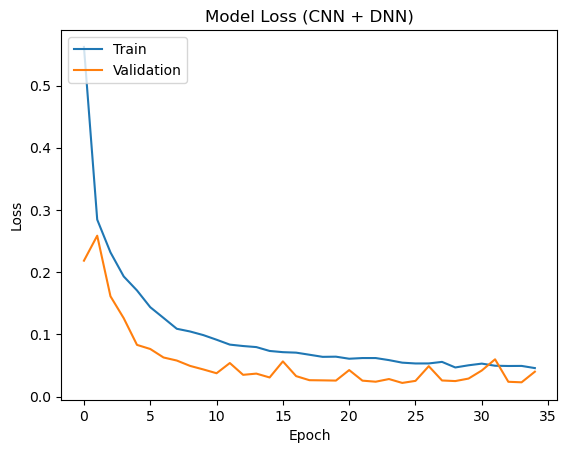

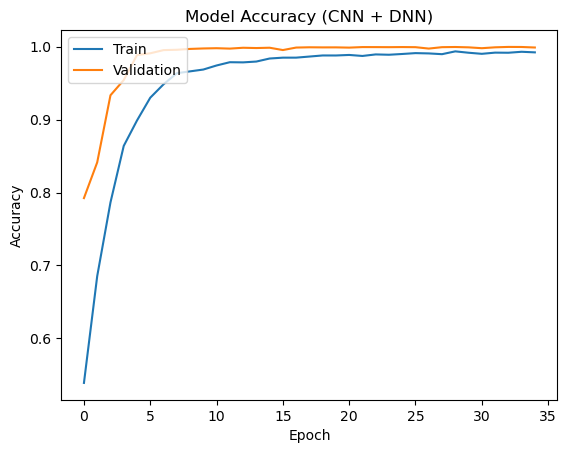

In [19]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# 1. 데이터 로드 및 전처리
X = df.drop(columns=['FG'])
y = df['FG']  # 타겟 클래스

# # 결측값(9)을 NaN으로 대체하고 나중에 처리
# X.replace(9, np.nan, inplace=True)

# # 결측치를 열 별 최빈값으로 대체
# X.fillna(df.mode().iloc[0], inplace=True)

# 데이터가 모두 숫자인지 확인하고, 필요시 변환
X = X.astype(float)

# 타겟이 이진 분류이므로 LabelEncoder로 변환할 필요 없음

# 2. 훈련 데이터와 테스트 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# CNN 입력 차원 조정 (1차원 배열로 변환)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# 3. CNN + DNN 모델 구성
model = Sequential()

# CNN 부분 (특성 추출)
model.add(Conv1D(64, 5, activation='gelu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))  # 드롭아웃 추가

model.add(Conv1D(32, 3, activation='gelu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))  # 드롭아웃 추가

model.add(Conv1D(16, 3, activation='gelu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Flatten())

# DNN 부분 (Fully Connected Layer)
model.add(Dense(32, activation='gelu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))  # DNN에서도 드롭아웃 적용
model.add(Dense(16, activation='gelu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# 출력층 (이진 분류를 위해 유닛 1개 및 sigmoid 활성화 함수 사용)
model.add(Dense(1, activation='sigmoid'))

# 4. 모델 컴파일 (이진 분류에 맞게 binary_crossentropy 사용)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])

# 5. 콜백 설정 및 모델 학습
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model_path = 'C:/Users/user/Desktop/CNN_DNN_binary_1023.weights.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

from tensorflow.keras.callbacks import LearningRateScheduler

# 학습률 스케줄러 함수 정의
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * 0.99  # 매 에포크마다 학습률을 1%씩 감소

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(x_train, y_train, 
                    epochs=1500, 
                    batch_size=128,  # 배치 크기를 조정하여 안정적인 학습
                    validation_data=(x_test, y_test), 
                    callbacks=[early_stop, checkpoint, lr_scheduler])  # 학습률 스케줄러 추가

# 6. 학습 결과 시각화 (손실 그래프)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (CNN + DNN)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 7. 학습 결과 시각화 (정확도 그래프)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model Accuracy (CNN + DNN)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [20]:
model.load_weights(model_path)

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9902834008097166
F1 Score: 0.9226804123711341
Precision: 0.9754768392370572
Recall: 0.8753056234718827
Cohen's Kappa: 0.9175125801664176


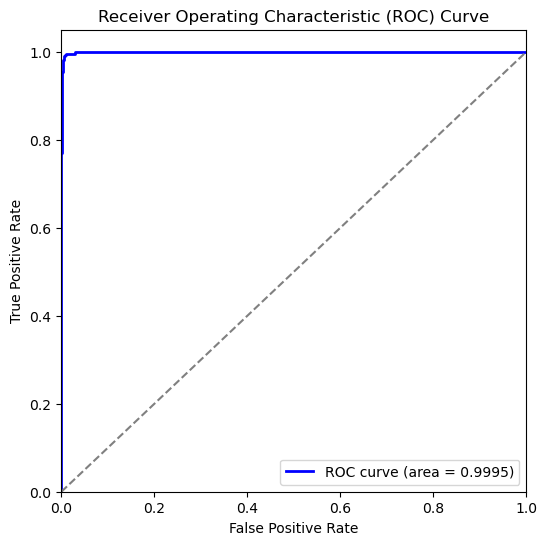

AUC: 0.9994623231878638


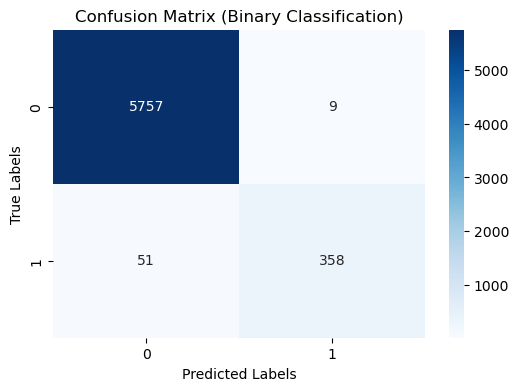

In [21]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# 1. 예측값 계산 (학습)
predictions = model.predict(x_test)  # 이진 분류에서는 각 클래스에 대한 확률 예측
actual = np.asarray(y_test)

# 이진 분류이므로 0.5를 기준으로 클래스 결정
pred = [1 if p >= 0.5 else 0 for p in predictions]  # 확률 값 기준으로 클래스 변환
act = actual.tolist()  # 실제값 그대로 사용 (이진 분류)

# DataFrame으로 변환
pred_df = pd.DataFrame(pred, columns=["예측값"])
actual_df = pd.DataFrame(act, columns=["실제값"])

# 2. 성능 지표 계산
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# 정확도
accuracy = accuracy_score(actual_df["실제값"], pred_df["예측값"])

# F1 스코어
f1 = f1_score(actual_df["실제값"], pred_df["예측값"])

# 정밀도 (Precision)
precision = precision_score(actual_df["실제값"], pred_df["예측값"])

# 재현율 (Recall)
recall = recall_score(actual_df["실제값"], pred_df["예측값"])

# 성능 결과 출력
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(actual_df["실제값"], pred_df["예측값"])
print(f"Cohen's Kappa: {kappa}")

# 3. ROC 커브 및 AUC 값 계산
fpr, tpr, thresholds = roc_curve(actual_df["실제값"], predictions)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# AUC 값 출력
print(f"AUC: {roc_auc}")

# 4. 혼동 행렬 계산 및 시각화
conf_matrix = confusion_matrix(actual_df["실제값"], pred_df["예측값"])

# 혼동 행렬 시각화
plt.figure(figsize=(6, 4))  # 이진 분류는 2x2 크기이므로 더 작은 사이즈로 설정
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix (Binary Classification)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 5. 결과 저장
result_df = pd.concat([pred_df, actual_df], axis=1)
result_df.to_excel("C:\\Users\\user\\Desktop\\CNN_DNN_binary_Pred_1023.xlsx", index=False)
